finished loading centerlines
finished calculating dem and slope along centerline


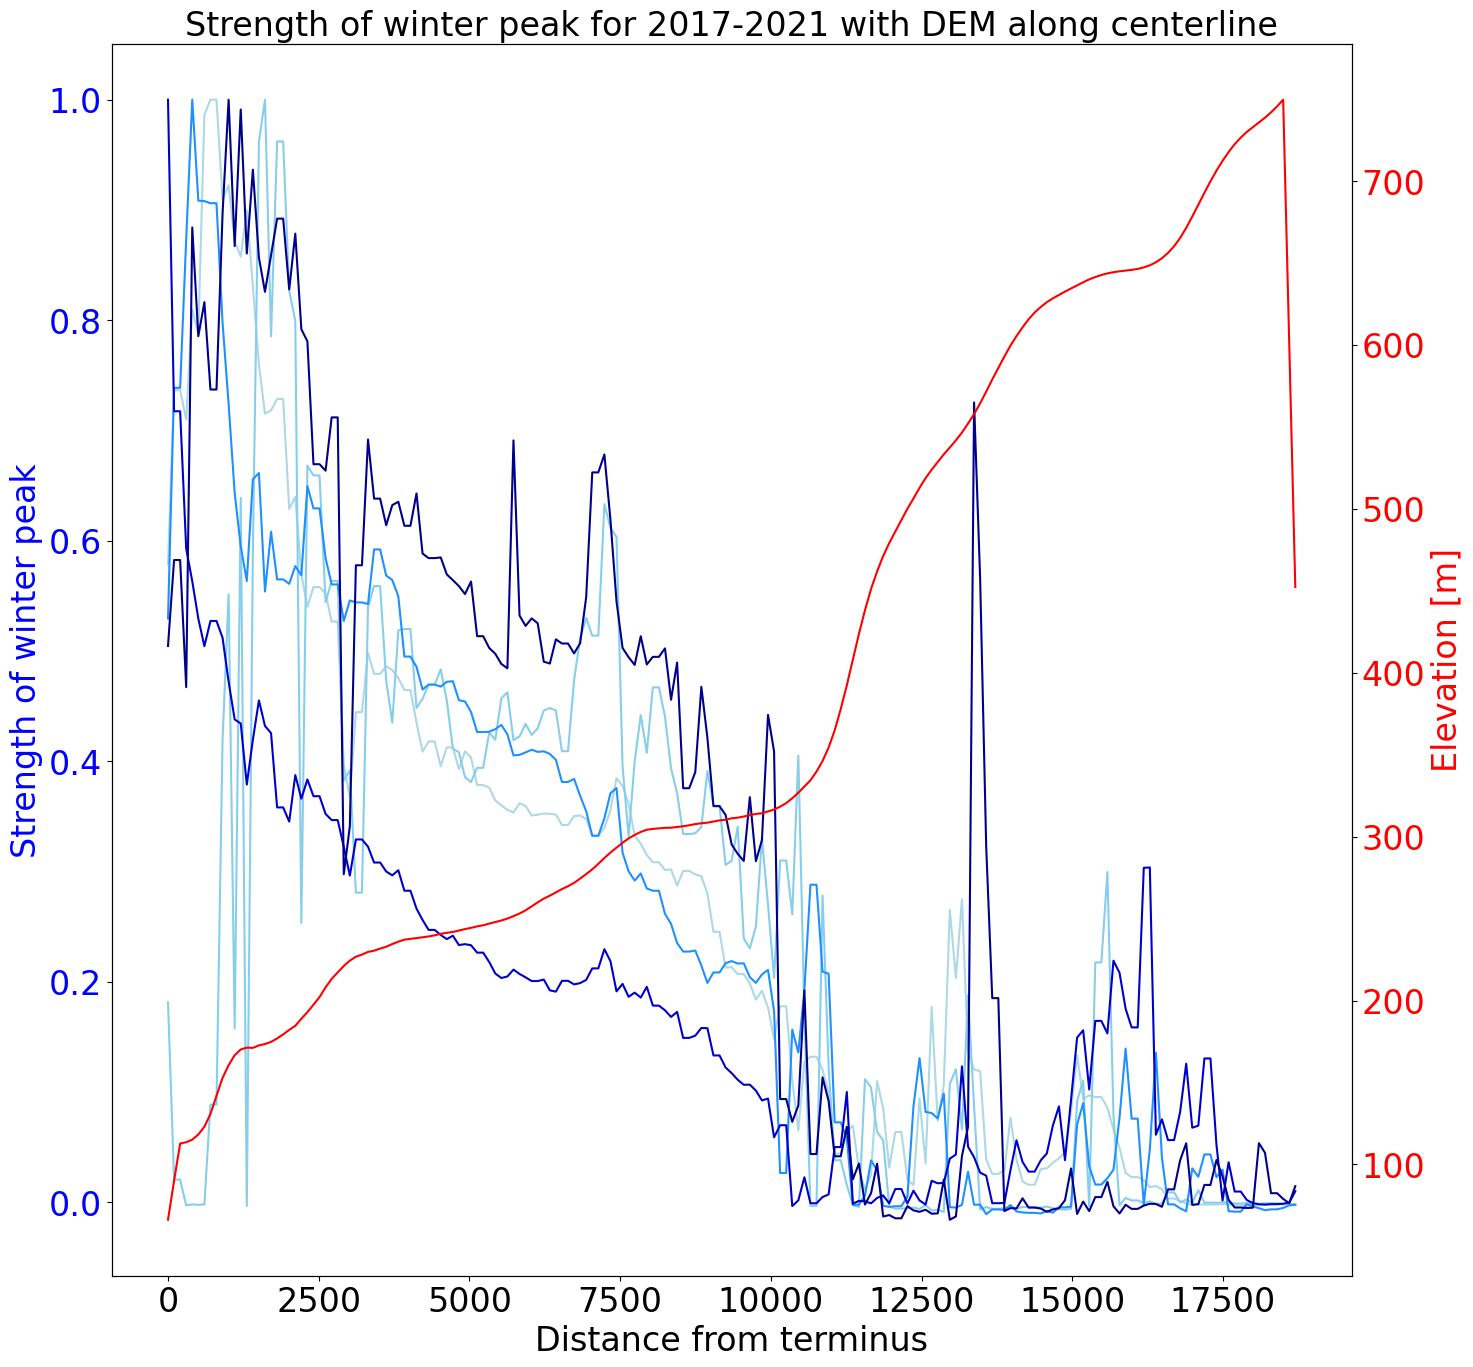

In [26]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import xarray
import scipy
from scipy.signal import savgol_filter
import xarray
from tqdm import tqdm
import rasterio as rio
import affine
import os
import elevation
import imageio.v2 as imageio
from matplotlib.colors import BoundaryNorm
import geopandas as gpd
from pyproj import Transformer
import matplotlib.colors as mcolors

fs = 24 #font size

########################
# strength and dem along centerline

fig, ax0 = plt.subplots(figsize=(16, 16))

########################
# load centerline

points = pd.read_csv('centerline_points_100m.csv')
x, y =points.X.to_numpy(), points.Y.to_numpy()

#distance from terminus along centerline 
d = np.linspace(100*len(x), 0, len(x))

print('finished loading centerlines')

########################

# load DEM
	
# Open the GeoTIFF file
with rio.open('ifsar_hubbardDEM_reproj.tif') as src:
	# Convert centerline coordinates to pixel indices
	i, j = rio.transform.rowcol(src.transform, x, y)

	# Read the raster data
	data = src.read(1)  # Assuming a single band image
	
	dem_centerline = data[i, j]
	n = 5
	dem_centerline = np.convolve(np.ones(n)/n, dem_centerline, mode="same")
	# Calculate the resolution (pixel size) of the DEM
	resolution = src.res[0]  # Assuming square pixels
	
	# Compute gradients using finite differences
	dz_dx, dz_dy = np.gradient(data, resolution)

	# Calculate slope magnitude
	slope_rad = np.arctan(np.sqrt(dz_dx**2 + dz_dy**2))
	slope_centerline = np.degrees(slope_rad[i,j])   
	
	#n = 10
	#slope_centerline = np.convolve(np.ones(n)/n, slope_centerline, mode="same")
	
# Combine target_x_idx, target_y_idx, and slope into a DataFrame
df1 = pd.DataFrame({'x': x, 'y': y, 'slope': slope_centerline})
df2 = pd.DataFrame({'x': x, 'y': y, 'dem': dem_centerline})
# Write the DataFrame to a CSV file
df1.to_csv('slope_along_centerline.csv')
df2.to_csv('dem_along_centerline.csv')

print('finished calculating dem and slope along centerline')

########################

ds = xarray.load_dataset("../Hubbard_5eminus5.nc")
ds["v"] = np.sqrt(ds.vx**2 + ds.vy**2).fillna(0)
ds["month"] = ds.time.dt.month
ds["year"] = ds.time.dt.year
ds["doy"] = ds.time.dt.dayofyear
xx, yy = np.meshgrid(ds.x, ds.y)
strength_centerline = np.zeros((len(x)))

years = [2017, 2018, 2019, 2020, 2021]
colors = ['#ADD8E6', '#87CEEB', '#1E90FF', '#0000CD', '#00008B']

for i, year in enumerate(years):

	winter_mask = np.logical_or(
		np.logical_and(ds.month >= 11, ds.year == year),
		np.logical_and(ds.month <= 2, ds.year == year+1)
	)
	
	winter_velocities = ds.v[winter_mask, :, :]
	winter_peak = winter_velocities.max(dim='time')

	middle_mask = np.logical_and(
		np.logical_and(ds.month >= 2.05, ds.month <= 4),
		ds.year == year+1,
	)
	middle_velocities = ds.v[middle_mask, :, :]
	min = middle_velocities.min(dim='time')

	summer_mask = np.logical_and(
		np.logical_and(ds.month >= 4, ds.month <= 6),
		ds.year == year+1,
	)
	summer_velocities = ds.v[summer_mask, :, :]
	summer_peak = summer_velocities.max(dim='time')

	###### calculate strength of double peaks 
	strength = (winter_peak - min)
    
	# find indices along centerline 
	for j in range(len(x)):
		# get indices of coordinates closest to points of interest
		target_x_idx = np.abs(xx[:, :] - x[j]).argmin(axis = 1)
		target_y_idx= np.abs(yy[:, :] - y[j]).argmin(axis = 0)
	
		 # Extract the slope value closest to the target coordinates
		strength_centerline[j] = strength[target_y_idx[0], target_x_idx[0]]

	#normalize and smooth
	strength_centerline =  strength_centerline/np.max(strength_centerline)
	#n = 25
	#strength_centerline = np.convolve(np.ones(n)/n, strength_centerline, mode="same")
			
	ax0.plot(d, strength_centerline, color=colors[i]) 
	


########################
ax0.set_xlabel('Distance from terminus', fontsize=fs)
ax0.set_ylabel('Strength of winter peak', fontsize=fs, color='b')
ax0.tick_params(axis='y', labelcolor='b', which='major', labelsize=fs)
ax0.tick_params(axis='x', which='major', labelsize=fs)

#second y-axis
ax1 = ax0.twinx()
ax1.plot(d, dem_centerline, 'r-')
ax1.set_ylabel('Elevation [m]', fontsize=fs, color='r')
ax1.tick_params(axis='y', labelcolor='r', which='major', labelsize=fs)
text_objs = plt.gcf().findobj(plt.Text)
for text_obj in text_objs:
	text_obj.set_fontsize(fs)
plt.title(f'Strength of winter peak for {years[0]}-{years[-1]} with DEM along centerline', fontsize=fs)
plt.show
plt.savefig(f'strength_dem_centerline_{years[0]}-{years[-1]}.png')
